<a href="https://colab.research.google.com/github/nitin-ng/AIE4/blob/main/Week%208/Day%201/Prototyping_LangChain_Application_with_Production_Minded_Changes_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ragas 0.1.20 requires langchain-core<0.3, but you have langchain-core 0.3.2 which is incompatible.
langchain-experimental 0.3.2 requires langchain-core<0.4.0,>=0.3.6, but you have langchain-core 0.3.2 which is incompatible.


We'll need an OpenAI API Key:

In [2]:
import os
import dotenv

dotenv.load_dotenv()

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

And the LangSmith set-up:

In [3]:
import uuid

langchainapikey = os.environ.get("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - b78a31e9


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [5]:
from ipywidgets import FileUpload
from IPython.display import display
import tempfile
import os
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [6]:
def process_uploaded_file(change):
    global docs  # Make docs a global variable
    if uploader.value:
        # Get the uploaded file
        uploaded_file = uploader.value[0]  # Access the first item of the tuple
        file_content = uploaded_file.content
        
        # Save the content to a temporary file
        with tempfile.NamedTemporaryFile(delete=False, suffix='.pdf', mode='wb') as temp_file:
            temp_file.write(file_content)
            temp_file_path = temp_file.name
        
        print(f"Temporary file created at: {temp_file_path}")
        print(f"File size: {os.path.getsize(temp_file_path)} bytes")
        
        # Check if the file is not empty
        if os.path.getsize(temp_file_path) > 0:
            try:
                # Load and process the PDF
                loader = PyMuPDFLoader(temp_file_path)
                documents = loader.load()
                
                # Initialize the text splitter
                text_splitter = RecursiveCharacterTextSplitter(
                    chunk_size=1000,
                    chunk_overlap=200,
                    length_function=len,
                )
                
                # Split the documents into chunks
                docs = text_splitter.split_documents(documents)
                
                print(f"Document split into {len(docs)} chunks.")
            except Exception as e:
                print(f"Error processing the PDF: {str(e)}")
        else:
            print("Error: The uploaded file is empty.")
        
        # Clean up the temporary file
        os.unlink(temp_file_path)

In [7]:
# Create and display the file uploader
uploader = FileUpload(accept='.pdf', multiple=False)
display(uploader)

# Attach the process_uploaded_file function to the uploader
uploader.observe(process_uploaded_file, names='value')

FileUpload(value=(), accept='.pdf', description='Upload')

Temporary file created at: /var/folders/jr/_qkyxp313390z32jmym7j9sm0000gp/T/tmpf9otru1t.pdf
File size: 6394463 bytes
Document split into 129 chunks.


In [10]:
if 'docs' in globals():
    vectorstore = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=cached_embedder)
    vectorstore.add_documents(docs)
    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})
    print("Vector store set up successfully.")
else:
    print("Error: 'docs' not defined. Please ensure the file is uploaded and processed.")


Vector store set up successfully.


In [11]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

# RAG Prompt setup
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

# Generation setup
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

# Setting up the cache
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

# RAG LCEL Chain
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

# Test the chain
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content="1. The document is a user manual for the Bosch Dishwasher model SPE68C75UC.\n2. It has a total of 60 pages.\n3. The manual is produced by BSH Hausgeräte GmbH, located in Munich, Germany.\n4. The document is formatted as a PDF 1.4 file.\n5. It includes essential installation instructions for the dishwasher.\n6. The author emphasizes the importance of reading and understanding all instructions before using the appliance.\n7. It provides safety instructions to reduce risks of fire, electrical shock, or serious injury.\n8. The manual advises keeping the document for future reference or for the next owner.\n9. The dishwasher model number is SPE68C75UC.\n10. The document was created on October 10, 2023.\n11. It includes troubleshooting information on page 16.\n12. The manual covers transportation, storage, and disposal of the appliance.\n13. It has a specific section for customer service details on page 18.\n14. The warranty statement is provided on page 20.\n15. The manua

We'll define our chunking strategy.

We'll chunk our uploaded PDF file.

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [12]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

Based on the context provided in the document, here are some suggested answers for Questions 1 and 2:

Question #1: Limitations and usefulness of cache-backed embeddings

Limitations:
1. Storage requirements: Caching embeddings requires additional storage space, which could become significant for large datasets.
2. Staleness: If the underlying embedding model is updated, cached embeddings may become outdated.
3. Initial overhead: The first-time embedding process still incurs the full cost and time.
4. Cache management: Implementing and maintaining the cache adds complexity to the system.

Most useful:
1. For frequently accessed documents or queries, reducing API calls and processing time.
2. In applications with limited bandwidth or high latency to embedding services.
3. When working with static datasets that don't change frequently.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [13]:
import time
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

# Set up the embeddings and cache
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Test text
test_text = "This is a sample text to test cache-backed embeddings."

# Function to measure embedding time
def time_embedding(embedder, text):
    start_time = time.time()
    _ = embedder.embed_query(text)
    end_time = time.time()
    return end_time - start_time

# First embedding (should take longer as it's not cached)
print("First embedding (not cached):")
first_time = time_embedding(cached_embedder, test_text)
print(f"Time taken: {first_time:.4f} seconds")

# Second embedding (should be faster due to cache)
print("\nSecond embedding (should be cached):")
second_time = time_embedding(cached_embedder, test_text)
print(f"Time taken: {second_time:.4f} seconds")

# Calculate and print the speedup
speedup = (first_time - second_time) / first_time * 100
print(f"\nSpeedup: {speedup:.2f}%")

First embedding (not cached):
Time taken: 0.6741 seconds

Second embedding (should be cached):
Time taken: 0.3694 seconds

Speedup: 45.20%


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [14]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [15]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [16]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

Limitations:
1. Lack of context sensitivity: Cached responses may not account for subtle changes in context or user intent.
2. Potential for outdated information: If the LLM is updated or fine-tuned, cached responses may become obsolete.
3. Storage requirements: Storing a large number of prompt-response pairs can be memory-intensive.
4. Reduced adaptability: Relying heavily on cached responses may limit the system's ability to provide novel or adaptive answers.

Most useful:
1. For frequently asked questions or common queries with stable answers.
2. In applications requiring quick response times, such as customer service chatbots.
3. To reduce costs associated with repeated API calls to language models.
4. For providing consistent answers to standard queries across multiple users.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [17]:
import time
from langchain_openai import ChatOpenAI
from langchain_core.caches import InMemoryCache
from langchain_core.globals import set_llm_cache

# Set up the LLM and cache
chat_model = ChatOpenAI(model="gpt-3.5-turbo")
set_llm_cache(InMemoryCache())

# Test prompt
test_prompt = "What is the capital of France?"

# Function to measure response time
def time_llm_response(model, prompt):
    start_time = time.time()
    _ = model.invoke(prompt)
    end_time = time.time()
    return end_time - start_time

# First response (should take longer as it's not cached)
print("First response (not cached):")
first_time = time_llm_response(chat_model, test_prompt)
print(f"Time taken: {first_time:.4f} seconds")

# Second response (should be faster due to cache)
print("\nSecond response (should be cached):")
second_time = time_llm_response(chat_model, test_prompt)
print(f"Time taken: {second_time:.4f} seconds")

# Calculate and print the speedup
speedup = (first_time - second_time) / first_time * 100
print(f"\nSpeedup: {speedup:.2f}%")

First response (not cached):
Time taken: 0.4863 seconds

Second response (should be cached):
Time taken: 0.0006 seconds

Speedup: 99.88%


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [18]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [19]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is a Use and Care Manual for the Bosch Dishwasher SPE68C75UC.\n2. The author of the document is BSH Hausgeräte GmbH.\n3. The document provides troubleshooting information.\n4. It includes details on transportation, storage, and disposal of the appliance.\n5. Instructions for removing the appliance are provided.\n6. Guidelines for vacation and storage of the appliance are included.\n7. Information on transporting the appliance is given.\n8. Instructions for disposing of the old appliance are provided.\n9. Customer service contact details are mentioned in the document.\n10. Model number (E-Nr.), production number (FD), and consecutive numbering (Z-Nr.) are discussed.\n11. AquaStop® Plus Pledge information is included.\n12. Technical specifications of the appliance are provided.\n13. Information regarding Free and Open Source Software is mentioned.\n14. The document contains a statement of limited product warranty.\n15. Details on what the warranty cover

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

In [20]:

# Set up the cache
cache = InMemoryCache()

# Add cache to the chain
cached_chain = retrieval_augmented_qa_chain.with_config(configurable={"cache": cache})

# Function to measure response time
def time_chain_response(chain, input_data):
    start_time = time.time()
    result = chain.invoke(input_data)
    end_time = time.time()
    return result, end_time - start_time

# Test input
test_input = {"question": "Write 50 things about this document!"}

# First run (not cached)
print("First run (not cached):")
first_result, first_time = time_chain_response(cached_chain, test_input)
print(f"Time taken: {first_time:.4f} seconds")

# Second run (should be cached)
print("\nSecond run (should be cached):")
second_result, second_time = time_chain_response(cached_chain, test_input)
print(f"Time taken: {second_time:.4f} seconds")

# Calculate and print the speedup
speedup = (first_time - second_time) / first_time * 100
print(f"\nSpeedup: {speedup:.2f}%")

# Compare results
print("\nResults comparison:")
print("First run result:")
print(first_result)
print("\nSecond run result:")

First run (not cached):
Time taken: 0.4437 seconds

Second run (should be cached):
Time taken: 0.2206 seconds

Speedup: 50.29%

Results comparison:
First run result:
content='1. The document is a Use and Care Manual for the Bosch Dishwasher SPE68C75UC.\n2. The author of the document is BSH Hausgeräte GmbH.\n3. The document provides troubleshooting information.\n4. It includes details on transportation, storage, and disposal of the appliance.\n5. Instructions for removing the appliance are provided.\n6. Guidelines for vacation and storage of the appliance are included.\n7. Information on transporting the appliance is given.\n8. Instructions for disposing of the old appliance are provided.\n9. Customer service contact details are mentioned in the document.\n10. Model number (E-Nr.), production number (FD), and consecutive numbering (Z-Nr.) are discussed.\n11. AquaStop® Plus Pledge information is included.\n12. Technical specifications of the appliance are provided.\n13. Information regar

In [21]:
import time
import logging
from datetime import datetime, timezone
from langsmith import Client
from tenacity import retry, stop_after_attempt, wait_fixed
from langchain_openai import ChatOpenAI
from langchain.evaluation import CriteriaEvalChain, StringEvaluator
from langchain.smith import RunEvalConfig

In [25]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

client = Client()

@retry(stop=stop_after_attempt(3), wait=wait_fixed(2))
def create_and_get_run(project_name, inputs):
    try:
        run = client.create_run(
            project_name=project_name,
            name="QA Evaluation",
            run_type="chain",
            inputs=inputs
        )
        if run is None:
            logger.info("Run created, but returned None. Attempting to fetch...")
            time.sleep(1)  # Wait a bit before trying to fetch
            runs = list(client.list_runs(project_name=project_name, limit=1))
            if runs:
                run = runs[0]
                logger.info(f"Retrieved run with ID: {run.id}")
            else:
                raise Exception("Failed to retrieve the created run")
        return run
    except Exception as e:
        logger.error(f"Error in run creation/retrieval: {e}", exc_info=True)
        raise

def setup_evaluators():
    eval_llm = ChatOpenAI(model="gpt-3.5-turbo")
    
    criteria = {
        "relevance": "The response should be highly relevant to the question asked.",
        "completeness": "The response should fully address all aspects of the question.",
        "accuracy": "The information provided in the response should be accurate and factual.",
        "clarity": "The response should be clear, well-structured, and easy to understand."
    }
    
    criteria_evaluator = CriteriaEvalChain.from_llm(
        llm=eval_llm,
        criteria=criteria
    )
    
    eval_config = RunEvalConfig(
        evaluators=[criteria_evaluator],
        custom_evaluators=[],
    )
    
    return eval_config

from datetime import datetime, timezone

def process_example(project_name, example, cached_chain, eval_config):
    run = create_and_get_run(project_name, example.inputs)
    if run is None:
        logger.warning(f"Failed to create or retrieve run for input: {example.inputs}")
        return

    try:
        # Execute the chain
        result = cached_chain.invoke(example.inputs)
        
        # Check if the run still exists and hasn't been completed
        try:
            existing_run = client.read_run(run.id)
            if existing_run.end_time:
                logger.info(f"Run {run.id} has already been completed. Skipping update.")
                return
        except Exception as e:
            logger.warning(f"Error checking run status: {e}")
            # If we can't check the status, we'll attempt to update anyway

        # Update the run with the result
        client.update_run(
            run.id,
            outputs=result,
            end_time=datetime.now(timezone.utc),
        )
        
        # Run evaluators
        for evaluator in eval_config.evaluators:
            if isinstance(evaluator, StringEvaluator):
                eval_result = evaluator.evaluate_strings(
                    prediction=result['text'] if isinstance(result, dict) else str(result),
                    input=example.inputs["question"],
                )
                client.create_feedback(
                    run.id,
                    evaluator.__class__.__name__,
                    score=eval_result.get("score"),
                    comment=eval_result.get("reasoning"),
                )
        
        logger.info(f"Completed evaluation for run {run.id}")
    except Exception as e:
        logger.error(f"Error processing run {run.id}: {e}", exc_info=True)
        try:
            client.update_run(
                run.id,
                error=str(e),
                end_time=datetime.now(timezone.utc),
            )
        except Exception as update_error:
            logger.error(f"Failed to update run {run.id} with error: {update_error}", exc_info=True)

def process_examples_in_batches(project_name, examples, cached_chain, eval_config, batch_size=5):
    for i in range(0, len(examples), batch_size):
        batch = examples[i:i+batch_size]
        for example in batch:
            process_example(project_name, example, cached_chain, eval_config)
        time.sleep(1)  # Add a small delay between batches

def main():
    project_name = "Test_Project_20241004_080054_535737"  # Your project name
    dataset_name = "qa_eval_dataset"  # Your dataset name
    
    examples = list(client.list_examples(dataset_name=dataset_name))
    logger.info(f"Processing {len(examples)} examples")
    
    eval_config = setup_evaluators()
    
    process_examples_in_batches(project_name, examples, cached_chain, eval_config)

if __name__ == "__main__":
    main()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.smith.langchain.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (2): api.smith.langchain.com:443
DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "GET /info HTTP/11" 200 485
DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "GET /datasets?limit=1&name=qa_eval_dataset HTTP/11" 200 435
DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "GET /sessions?limit=1 HTTP/11" 200 771
DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "GET /examples?offset=0&inline_s3_urls=True&limit=100&dataset=c992bfb8-4a05-4d62-b44b-76a67620b4b6 HTTP/11" 200 20287
INFO:__main__:Processing 51 examples
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='/opt/anaconda3/envs/llmops-course/lib/python3.11/site-packages/certifi/cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True htt

![Screenshot 2024-10-04 at 4.12.39 PM.png](<attachment:Screenshot 2024-10-04 at 4.12.39 PM.png>)
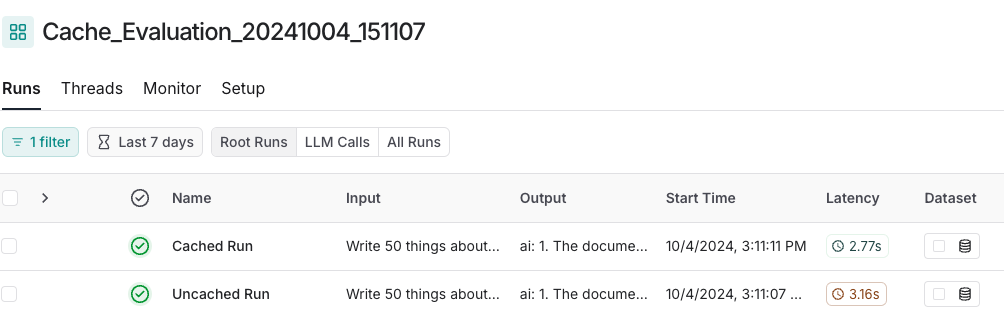